# Tutorial 3 - How to use ordinal preferences instead of cardinal

In this notebook, we are going to see how to implement an election with **ordinal preferences** in our model of voters with embeddings.

An election with **ordinal preferences** corresponds to an election in which each voter gives a **ranking** of the candidates instead of giving a different **score** to each candidate. It has been studied a lot and many rules exists for this model (*Plurality, Borda, k-approval, Condorcet, Instand Runoff, Maximin, etc.*).

In [1]:
import embedded_voting as ev
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(442)

## Classic election

Let's **run an election** with **5 candidates** and **100 voters**. We obtain the following profile:

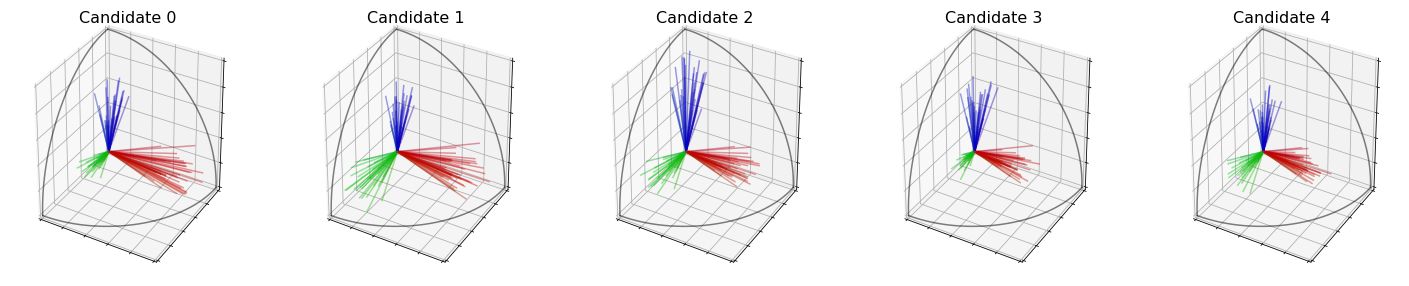

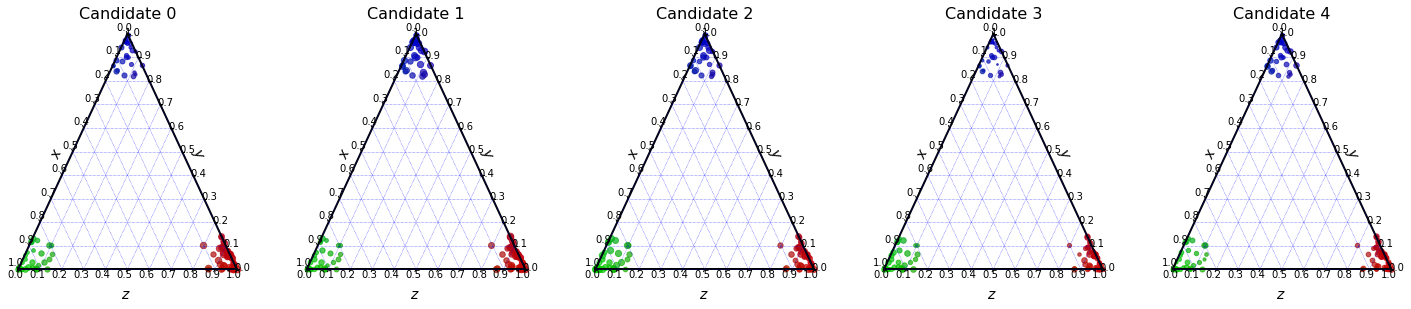

In [2]:
n_voters = 100
n_candidates = 5
n_dimensions = 3

embeddingsGen = ev.EmbeddingsGeneratorPolarized(n_voters, n_dimensions)
ratingsGen = ev.RatingsFromEmbeddingsCorrelated(n_candidates, n_dimensions)

embeddings = embeddingsGen(polarisation=0.5)
profile = ratingsGen(embeddings, coherence=0.6)

embeddings.plot_candidates(profile, "3D")
embeddings.plot_candidates(profile, "ternary")

In [3]:
election = ev.SVDNash()
election(profile, embeddings)

We can also print **all the information** about the results of this rule:

In [4]:
print('Scores : ', election.scores_)
print('Ranking : ', election.ranking_)
print('Winner : ', election.winner_)
print('Welfare : ', election.welfare_)

Scores :  [55.71130720288435, 74.7790763887831, 72.65667674609678, 36.16631091952898, 45.76168319793377]
Ranking :  [1, 2, 0, 4, 3]
Winner :  1
Welfare :  [0.5061796544699267, 1.0, 0.9450337312830829, 0.0, 0.24850259135272817]


## Positional scoring rules

Now, let's assume that instead of asking a **score vector** to each voter, we ask for a **ranking** of the candidate, and apply some rule with all the rankings.

A broad family of rule are **positional scoring rule**. A positional scoring rule is characterized by a vector $p = (p_1, \ldots, p_m)$ such that each voter $v_i$ gives $p_j$ points to the voters with rank $j$. The winner is the candidate with the maximum total score.

We can adapt this idea to scores between $0$ and $1$ by setting the score given by the voter $v_i$ to candidate $c_j$ as $\frac{p_k}{p_n}$ if the candidate $c_j$ is ranked at position $k$ in the ranking of $v_i$.

For instance, if the positional scoring rule is $(2, 1, 1, 1, 0)$, each voter gives a score of $1$ to her favorite candidate, $0$ to her least favorite candidate and $\frac{1}{2}$ to every other candidate:

In [5]:
ordinal_election = ev.PositionalRuleExtension([2, 1, 1, 1, 0], rule=ev.SVDNash())
ordinal_election(profile, embeddings)

If we plot the profile of the candidates now, it is very different than before:

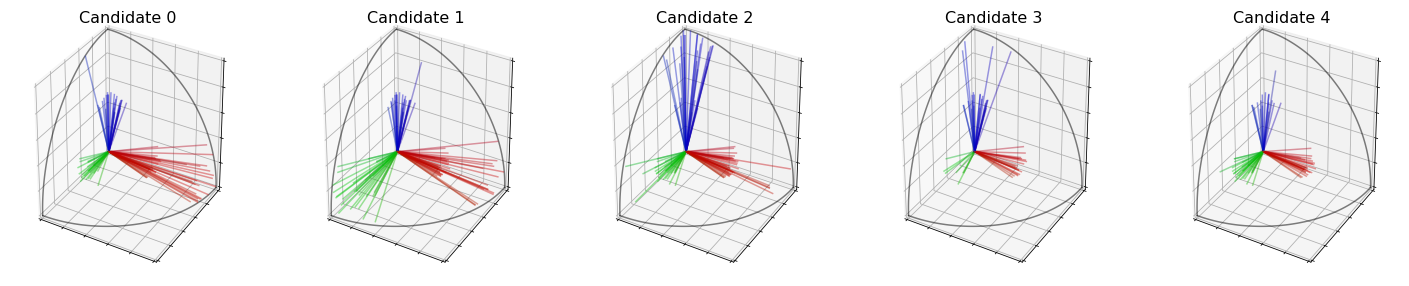

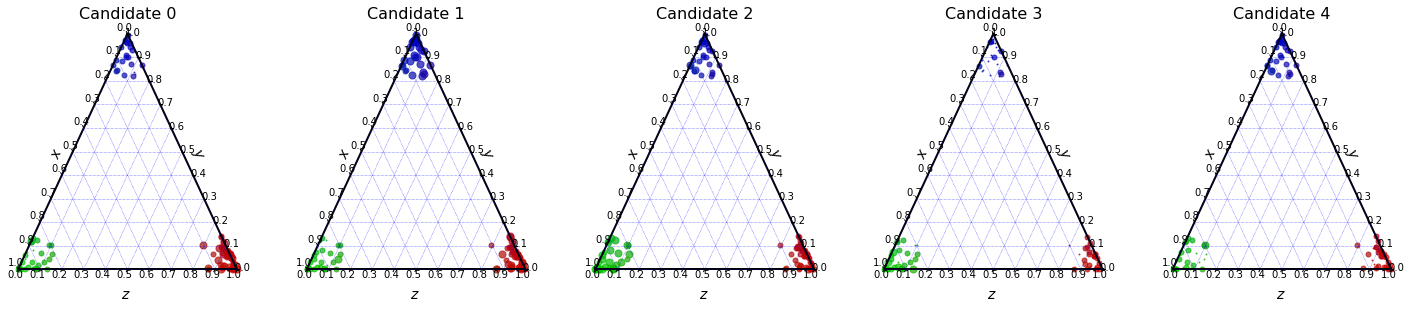

In [6]:
ordinal_election.plot_fake_ratings("3D")
ordinal_election.plot_fake_ratings("ternary")

In [7]:
print('Scores : ', ordinal_election.score_(1))
print('Ranking : ', ordinal_election.ranking_)
print('Winner : ', ordinal_election.winner_)

Scores :  83.34064074813169
Ranking :  [1, 2, 0, 4, 3]
Winner :  1


### Plurality

**Plurality** is the positional scoring rule defined by the scoring vector $(1, 0, \ldots, 0)$. It is equivalent to saying that each voter only vote for his favorite candidate. We can see that in that case, almost nobody voted for candidate $c_4$:

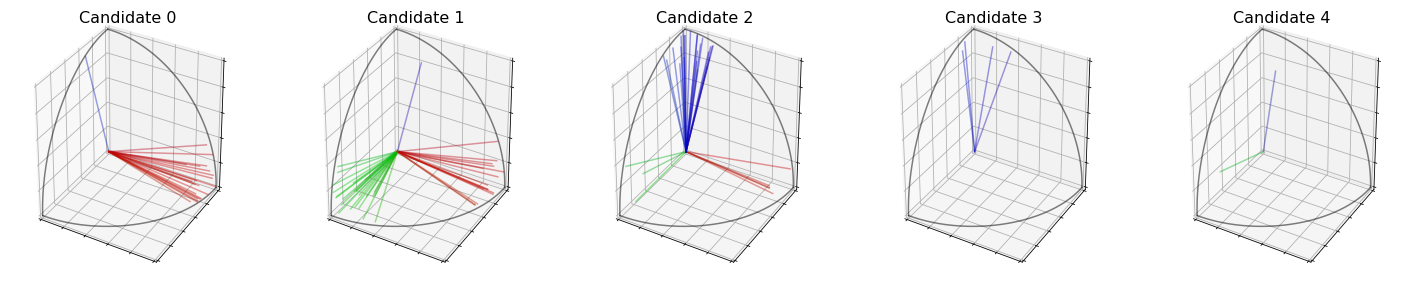

In [8]:
plurality_election = ev.PluralityExtension(n_candidates, rule=ev.SVDNash())
plurality_election(profile, embeddings)
plurality_election.plot_fake_ratings("3D")

In [9]:
print('Scores : ', plurality_election.scores_)
print('Ranking : ', plurality_election.ranking_)
print('Winner : ', plurality_election.winner_)

Scores :  [2.4819696283757775, 18.20503583288755, 16.882505862913728, 0.0439046062478178, 4.4801931645842635e-09]
Ranking :  [1, 2, 0, 3, 4]
Winner :  1


### Veto

The **Veto** is the opposite of Plurality. In this rule, every voter votes for all candidates **but one**. That is why it looks like every candidate is liked by a lot of voters:

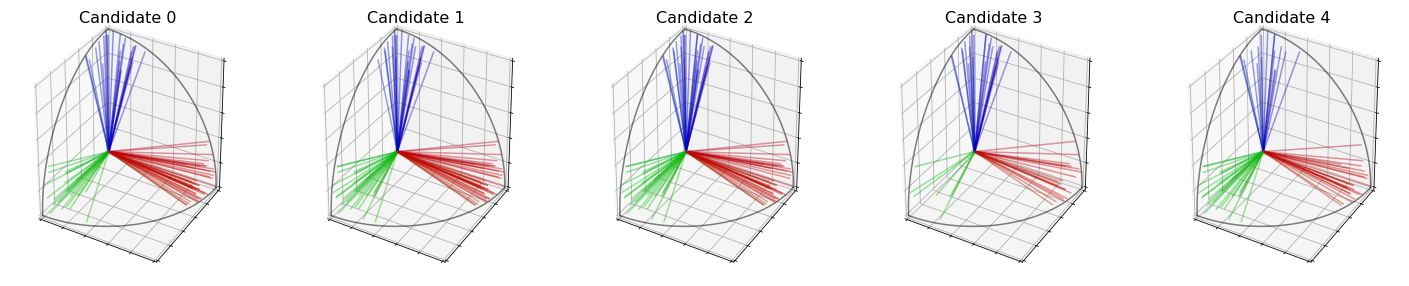

In [10]:
veto_election = ev.VetoExtension(n_candidates, rule=ev.SVDNash())
veto_election(profile, embeddings)
veto_election.plot_fake_ratings("3D")

In [11]:
print('Scores : ', veto_election.scores_)
print('Ranking : ', veto_election.ranking_)
print('Winner : ', veto_election.winner_)

Scores :  [127.62553018042959, 144.4885066259055, 149.3675459369369, 50.90745275837788, 87.57321665292172]
Ranking :  [2, 1, 0, 4, 3]
Winner :  2


### k-Approval

**K-approval** is the rule in between Plurality and Veto. Each voter votes for his **k** favorite candidates only. For instance, with $k=3$ :

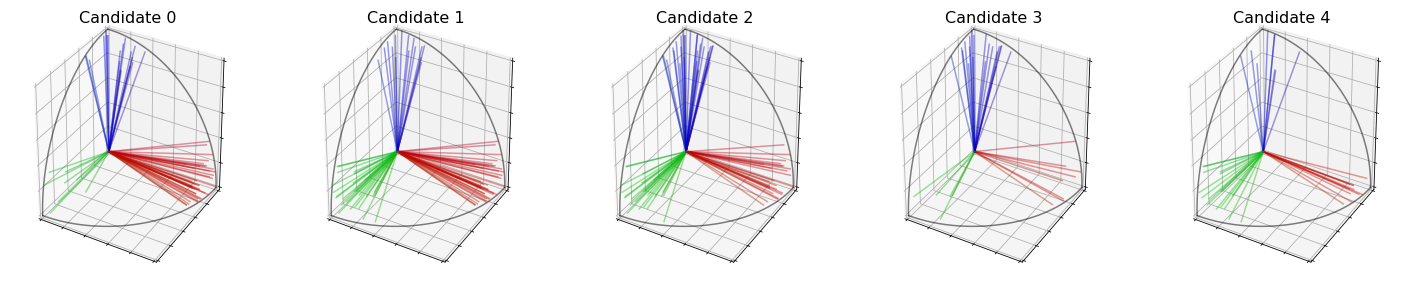

In [12]:
kapp_election = ev.KApprovalExtension(n_candidates, k=3, rule=ev.SVDNash())
kapp_election(profile, embeddings)
kapp_election.plot_fake_ratings("3D")

In [13]:
print('Scores : ', kapp_election.scores_)
print('Ranking : ', kapp_election.ranking_)
print('Winner : ', kapp_election.winner_)

Scores :  [67.35211008094713, 108.92755394551901, 114.58820903393773, 24.283783596789725, 34.52955693787184]
Ranking :  [2, 1, 0, 4, 3]
Winner :  2


### Borda

**Borda** use the scoring vector $(m-1, m-2, \ldots, 1, 0)$ where $m$ is the total number of candidates.

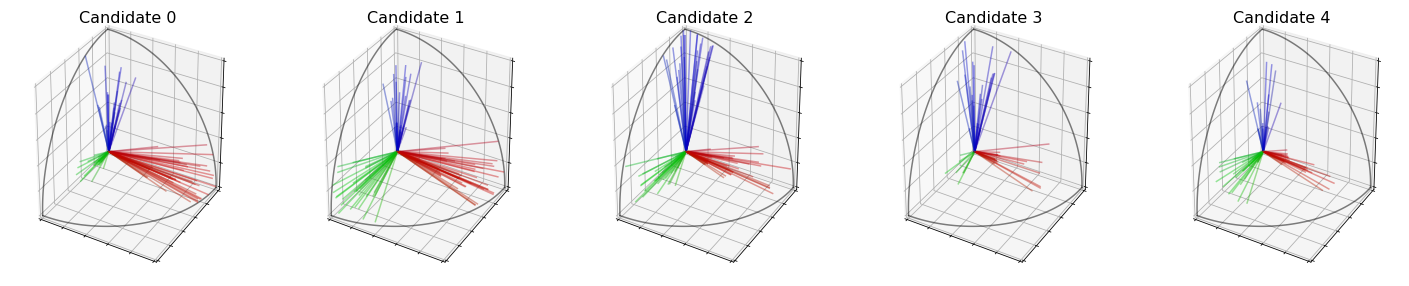

In [14]:
borda_election = ev.BordaExtension(n_candidates, rule=ev.SVDNash())
borda_election(profile, embeddings)
borda_election.plot_fake_ratings("3D")

In [15]:
print('Scores : ', borda_election.scores_)
print('Ranking : ', borda_election.ranking_)
print('Winner : ', borda_election.winner_)

Scores :  [50.718603692425056, 86.51414533786296, 83.15668902553821, 17.593981815609332, 27.04763179123942]
Ranking :  [1, 2, 0, 4, 3]
Winner :  1


## Instant Runoff Voting (IRV)

Finally, we implemented **Instant Runoff Voting** which is not a positional scoring rule.

In this voting system, at each step, every voter votes for his favorite candidate, and the candidate with the lowest score **is eliminated**. Consequently, we perform $m-1$ elections before we can find the winner. The ranking obtained is the inverse of the order in which the candidates are eliminated.

In [16]:
irv_election = ev.InstantRunoffExtension(rule=ev.SVDNash())
irv_election(profile, embeddings)

In [17]:
print('Ranking : ', irv_election.ranking_)
print('Winner : ', irv_election.winner_)

Ranking :  [1, 2, 0, 3, 4]
Winner :  1


You can see that we can obtain different rankings depending on the ordinal voting rule that we use.